In [1]:
cd /home/c01muya/vae-disentanglement/disentanglement_lib_pl

/home/c01muya/vae-disentanglement/disentanglement_lib_pl


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

from vae_experiment import VAEExperiment
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
from notebook_utils import *

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

In [3]:
npz_path = "../datasets/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"
dsprites = load_dsprites(npz_path)

In [4]:
curr_dev = torch.device("cuda:4")
batch_size = 144
seed = 123

In [5]:
beta = 1.0
z_dim = 6
batch_size = 144
checkpoint_path="../pl-dt-test/dsprites_full_beta1/version_0/checkpoints/epoch=51-step=539135.ckpt"

acts_for_dsprites_full, dsprites_full_dataset, model_dsprites_full  = load_model_and_data_and_get_activations(
                    dset_name='dsprites_full', dset_path='../datasets', 
                    batch_size=batch_size, z_dim=z_dim , beta=beta, 
                    checkpoint_path=checkpoint_path, current_device=curr_dev, 
                    activation_with_label=False, seed=123,  batches=2000
    )

 43%|█████████████████▊                       | 2000/4608 [00:09<00:12, 205.51it/s]


Moving heart from right to left


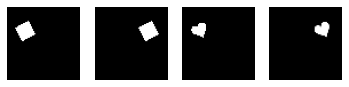

In [6]:
latents_sampled = np.array([ 
    [0, 0, 2, 3, 0, 5],
    [0, 0, 2, 3, 30, 5],
    [0, 2, 2, 3, 0, 5]
])
indices_sampled = latent_to_index(latents_sampled, dsprites['latents_bases'])
imgs_sampled = dsprites['images'][indices_sampled]
print("Moving heart from right to left")
mus, logvars, new_img = do_semantic_manipulation(imgs_sampled, model_dsprites_full, curr_dev)

Transferring rotation to an unrotated ellipse


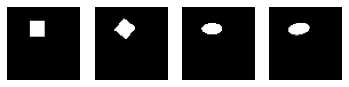

In [7]:
latents_sampled = np.array([ 
    [0, 0, 2, 0, 10, 3],
    [0, 0, 2, 25, 10, 3],
    [0, 1, 2, 0, 10, 3]
])
indices_sampled = latent_to_index(latents_sampled, dsprites['latents_bases'])
imgs_sampled = dsprites['images'][indices_sampled]

print("Transferring rotation to an unrotated ellipse")
mus, logvars, new_img = do_semantic_manipulation(imgs_sampled, model_dsprites_full, curr_dev)

Transferring rotation to an unrotated heart


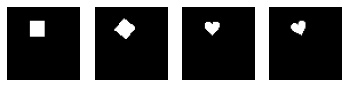

In [10]:
latents_sampled = np.array([ 
    [0, 0, 2, 0, 10, 3],
    [0, 0, 2, 25, 10, 3],
    [0, 2, 2, 0, 10, 3]
])
indices_sampled = latent_to_index(latents_sampled, dsprites['latents_bases'])
imgs_sampled = dsprites['images'][indices_sampled]

print("Transferring rotation to an unrotated heart")
mus, logvars, new_img = do_semantic_manipulation(imgs_sampled, model_dsprites_full, curr_dev)

Changing scale of heart from smallest to largest


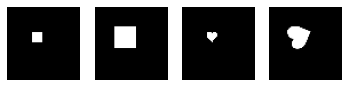

In [8]:
latents_sampled = np.array([ 
    [0, 0, 0, 0, 10, 10],
    [0, 0, 5, 0, 10, 10],
    [0, 2, 0, 0, 10, 10]
])
indices_sampled = latent_to_index(latents_sampled, dsprites['latents_bases'])
imgs_sampled = dsprites['images'][indices_sampled]

print("Changing scale of heart from smallest to largest")
mus, logvars, new_img = do_semantic_manipulation(imgs_sampled, model_dsprites_full, curr_dev)

Changing scale of ellipse from smallest to largest


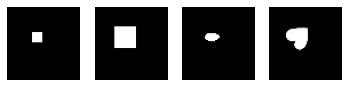

In [9]:
latents_sampled = np.array([ 
    [0, 0, 0, 0, 10, 10],
    [0, 0, 5, 0, 10, 10],
    [0, 1, 0, 0, 10, 10]
])
indices_sampled = latent_to_index(latents_sampled, dsprites['latents_bases'])
imgs_sampled = dsprites['images'][indices_sampled]

print("Changing scale of ellipse from smallest to largest")
mus, logvars, new_img = do_semantic_manipulation(imgs_sampled, model_dsprites_full, curr_dev)

For factor 1 (shape) estimated responsible dim is 1.
For factor 2 (scale) estimated responsible dim is 3.
For factor 3 (orientation) estimated responsible dim is 1.
For factor 4 (posX) estimated responsible dim is 2.
For factor 5 (posY) estimated responsible dim is 4.


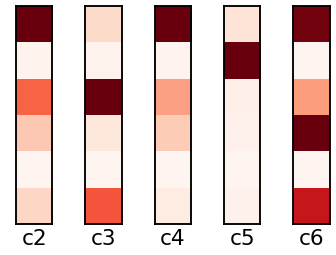

In [16]:
factors = ('color', 'shape', 'scale', 'orientation', 'posX', 'posY')
dimwise_variances = np.zeros(shape=(5,6))

for factor_idx in range(1,6):
    
    pairs = sample_latent_pairs_differing_in_one_factor(factor_idx, dsprites, how_many_pairs=10000)
    _, dimwise_variance, est_resp_dim = estimate_responsible_dimension(pairs, model_dsprites_full, curr_dev)
    dimwise_variances[factor_idx - 1, :] = dimwise_variance
    print(f"For factor {factor_idx} ({factors[factor_idx]}) estimated responsible dim is {est_resp_dim + 1}.")

fig, axs = plt.subplots(1,5)
for i, dv in enumerate(dimwise_variances):
    
    axs[i].imshow(np.expand_dims(dv, axis=1), cmap='Reds', interpolation='nearest')
    axs[i].set_yticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    axs[i].set_xlabel('c'+str(i+2))

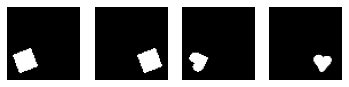

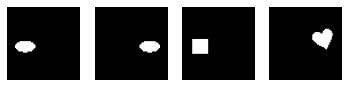

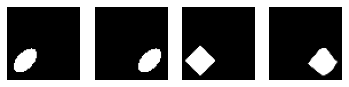

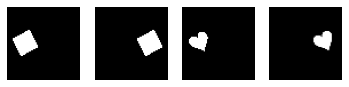

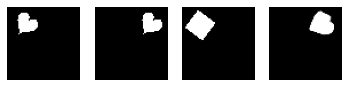

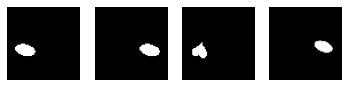

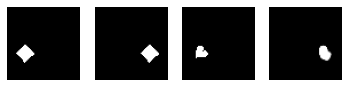

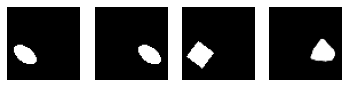

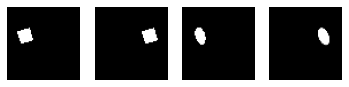

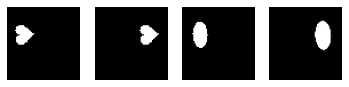

In [13]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=4, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10,
    latent_max_val=dsprites['latents_sizes'][4]-1)

# we do a semantic tr for every pair

for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)
    

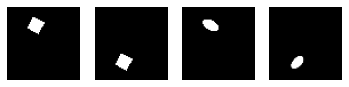

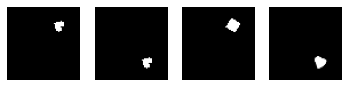

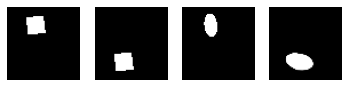

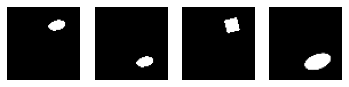

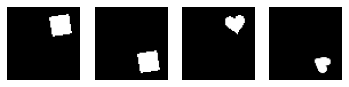

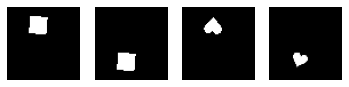

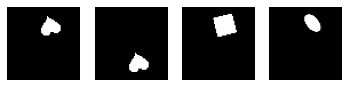

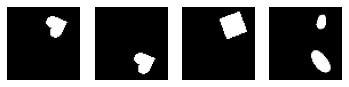

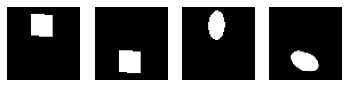

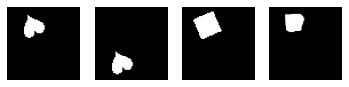

In [13]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=5, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10)

# we do a semantic tr for every pair

for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)

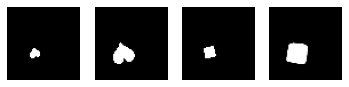

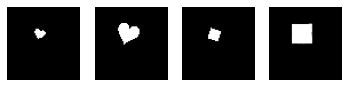

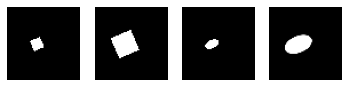

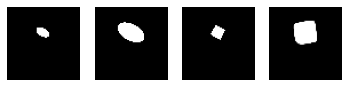

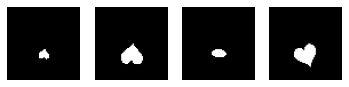

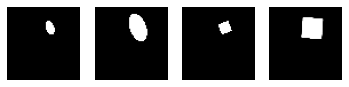

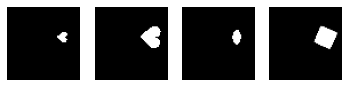

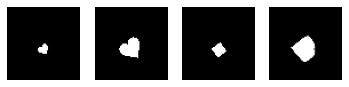

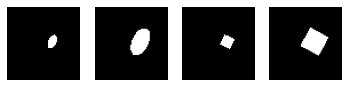

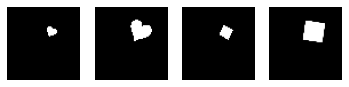

In [14]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=2, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10)

# we do a semantic tr for every pair

for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)

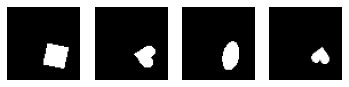

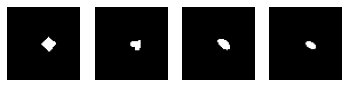

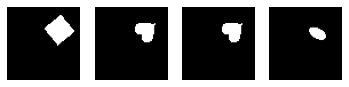

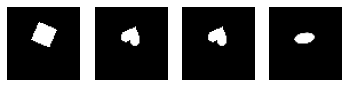

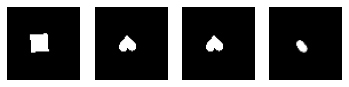

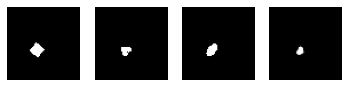

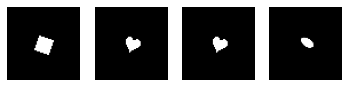

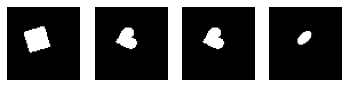

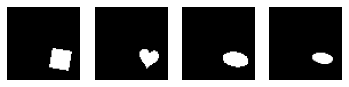

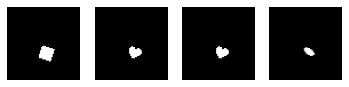

In [15]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=1, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10)

# we do a semantic tr for every pair

for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)

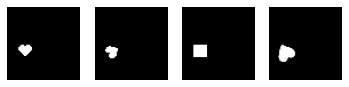

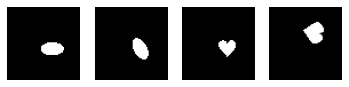

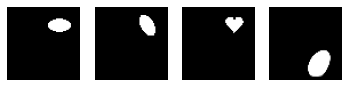

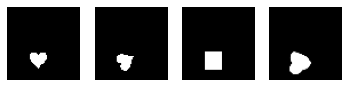

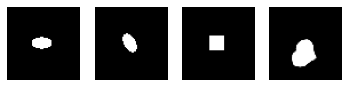

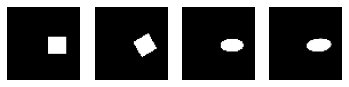

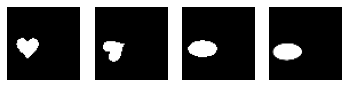

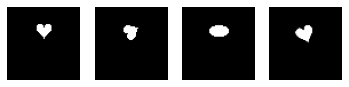

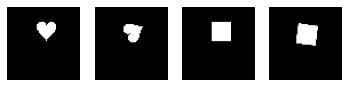

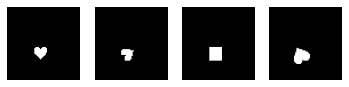

In [15]:
max_diff_pairs = sample_latent_pairs_maximally_differing_in_one_factor(
    diff_factor_idx=3, 
    npz_dataset=dsprites, 
    direction='min-to-max', 
    how_many_pairs=10,
    latent_max_val=dsprites['latents_sizes'][3]//3)

# we do a semantic tr for every pair

for pairs in max_diff_pairs:
    
    mus, logvars, new_img = do_semantic_manipulation(pairs['images'], model_dsprites_full, curr_dev)